In [2]:
import pyspark
import pandas as pd
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
spark = SparkSession.builder.appName("DataFrame").getOrCreate()

In [4]:
spark

In [5]:
df = spark.read.csv('archive/ChocolateSales.csv', header=True, inferSchema=True)

In [6]:
from pyspark.sql.functions import to_date, regexp_replace, trim, col
df = df.withColumn("Date", to_date(col("Date"), "dd-MMM-yy"))
df = df.withColumn("Amount", trim(regexp_replace(regexp_replace(col('Amount'), r'\$', ''), r',', '')).cast('float'))

In [7]:
df.show(5)

+--------------+---------+-------------------+----------+-------+-------------+
|  Sales Person|  Country|            Product|      Date| Amount|Boxes Shipped|
+--------------+---------+-------------------+----------+-------+-------------+
|Jehu Rudeforth|       UK|    Mint Chip Choco|2022-01-04| 5320.0|          180|
|   Van Tuxwell|    India|      85% Dark Bars|2022-08-01| 7896.0|           94|
|  Gigi Bohling|    India|Peanut Butter Cubes|2022-07-07| 4501.0|           91|
|  Jan Morforth|Australia|Peanut Butter Cubes|2022-04-27|12726.0|          342|
|Jehu Rudeforth|       UK|Peanut Butter Cubes|2022-02-24|13685.0|          184|
+--------------+---------+-------------------+----------+-------+-------------+
only showing top 5 rows



In [8]:
df.printSchema()

root
 |-- Sales Person: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Amount: float (nullable = true)
 |-- Boxes Shipped: integer (nullable = true)



### Verificando valores nullos

In [9]:
from pyspark.sql.functions import col, sum


null_counts = df.select([sum(col(c).isNull().cast('int')).alias(c) for c in df.columns])
null_counts.show()

+------------+-------+-------+----+------+-------------+
|Sales Person|Country|Product|Date|Amount|Boxes Shipped|
+------------+-------+-------+----+------+-------------+
|           0|      0|      0|   0|     0|            0|
+------------+-------+-------+----+------+-------------+



### Valores Unicos

In [10]:
cateogorical_cols = ['Sales Person', 'Country', 'Product']

print("\nValores Unicos em cada coluna:")
for col_names in cateogorical_cols:
    # Contando o numero de valores unicos
    unique_count = df.select(col_names).distinct().count()
    print(f"\n{col_names}: {unique_count} valores unicos")

    # Contagem dos valores por categoria
    print(f"\nContagem dos valores em {col_names}:")
    df.groupBy(col_names).count().orderBy('count', ascending=False).show(10, truncate=False)


Valores Unicos em cada coluna:

Sales Person: 25 valores unicos

Contagem dos valores em Sales Person:
+-------------------+-----+
|Sales Person       |count|
+-------------------+-----+
|Kelci Walkden      |54   |
|Brien Boise        |53   |
|Van Tuxwell        |51   |
|Beverie Moffet     |50   |
|Dennison Crosswaite|49   |
|Oby Sorrel         |49   |
|Ches Bonnell       |48   |
|Karlen McCaffrey   |47   |
|Gigi Bohling       |47   |
|Curtice Advani     |46   |
+-------------------+-----+
only showing top 10 rows


Country: 6 valores unicos

Contagem dos valores em Country:
+-----------+-----+
|Country    |count|
+-----------+-----+
|Australia  |205  |
|India      |184  |
|USA        |179  |
|UK         |178  |
|Canada     |175  |
|New Zealand|173  |
+-----------+-----+


Product: 22 valores unicos

Contagem dos valores em Product:
+-------------------+-----+
|Product            |count|
+-------------------+-----+
|Eclairs            |60   |
|50% Dark Bites     |60   |
|Smooth Sliky 

### Começando o EDA

1. Montante de Vendas

In [11]:
df_pandas = df.toPandas()

In [12]:
df_pandas

,Sales Person,Country,Product,Date,Amount,Boxes Shipped
0,Jehu Rudeforth,UK,Mint Chip Choco,2022-01-04,5320.0,180
1,Van Tuxwell,India,85% Dark Bars,2022-08-01,7896.0,94
2,Gigi Bohling,India,Peanut Butter Cubes,2022-07-07,4501.0,91
3,Jan Morforth,Australia,Peanut Butter Cubes,2022-04-27,12726.0,342
4,Jehu Rudeforth,UK,Peanut Butter Cubes,2022-02-24,13685.0,184
...,...,...,...,...,...,...
1089,Karlen McCaffrey,Australia,Spicy Special Slims,2022-05-17,4410.0,323
1090,Jehu Rudeforth,USA,White Choc,2022-06-07,6559.0,119
1091,Ches Bonnell,Canada,Organic Choco Syrup,2022-07-26,574.0,217
1092,Dotty Strutley,India,Eclairs,2022-07-28,2086.0,384


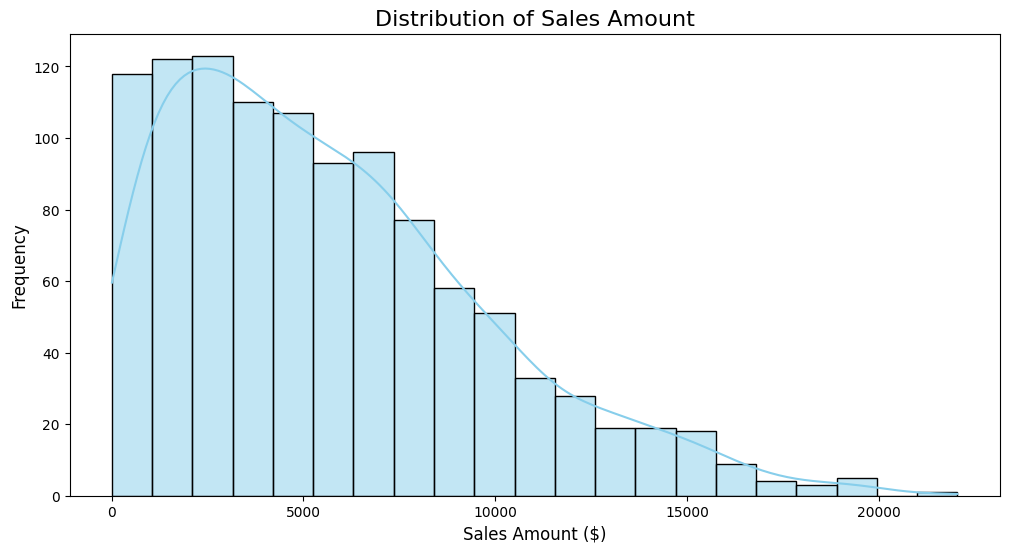

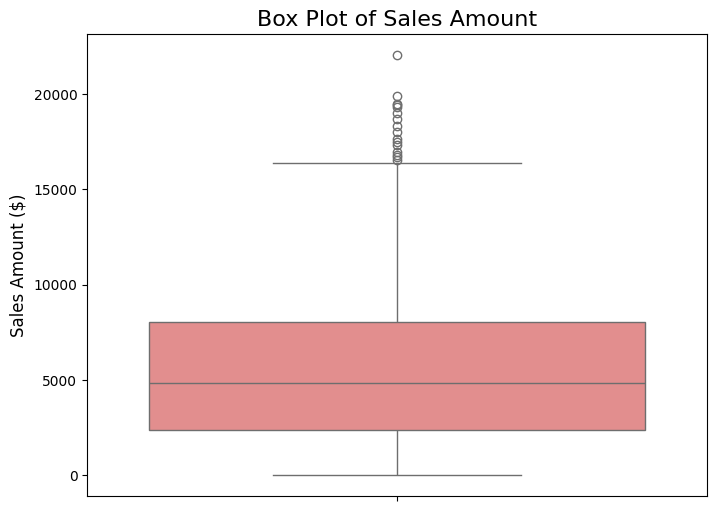

In [13]:
plt.figure(figsize=(12, 6))
sns.histplot(df_pandas['Amount'], kde=True, color='skyblue')
plt.title('Distribution of Sales Amount', fontsize=16)
plt.xlabel('Sales Amount ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(y=df_pandas['Amount'], color='lightcoral')
plt.title('Box Plot of Sales Amount', fontsize=16)
plt.ylabel('Sales Amount ($)', fontsize=12)
plt.show()

2. Vendas por País

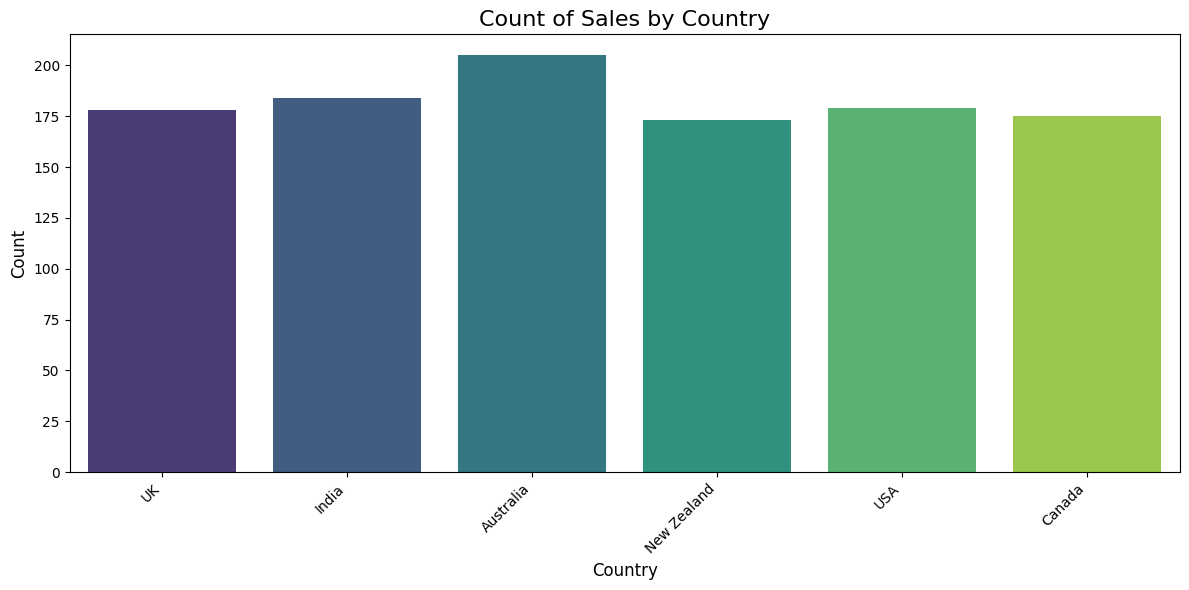

In [15]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_pandas, x='Country', palette='viridis', hue='Country', legend=False)
plt.title('Count of Sales by Country', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

3. Vendas por Produto

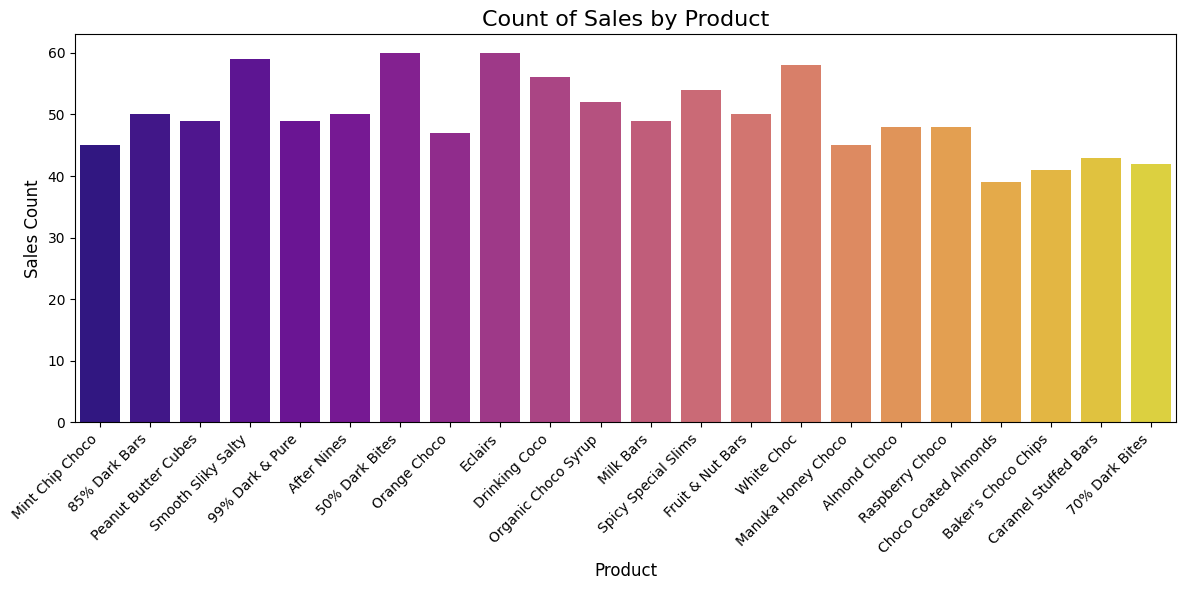

In [16]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_pandas, x='Product', palette='plasma', hue='Product', legend=False)
plt.title('Count of Sales by Product', fontsize=16)
plt.xlabel('Product', fontsize=12)
plt.ylabel('Sales Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

4. Vendas por Pessoas

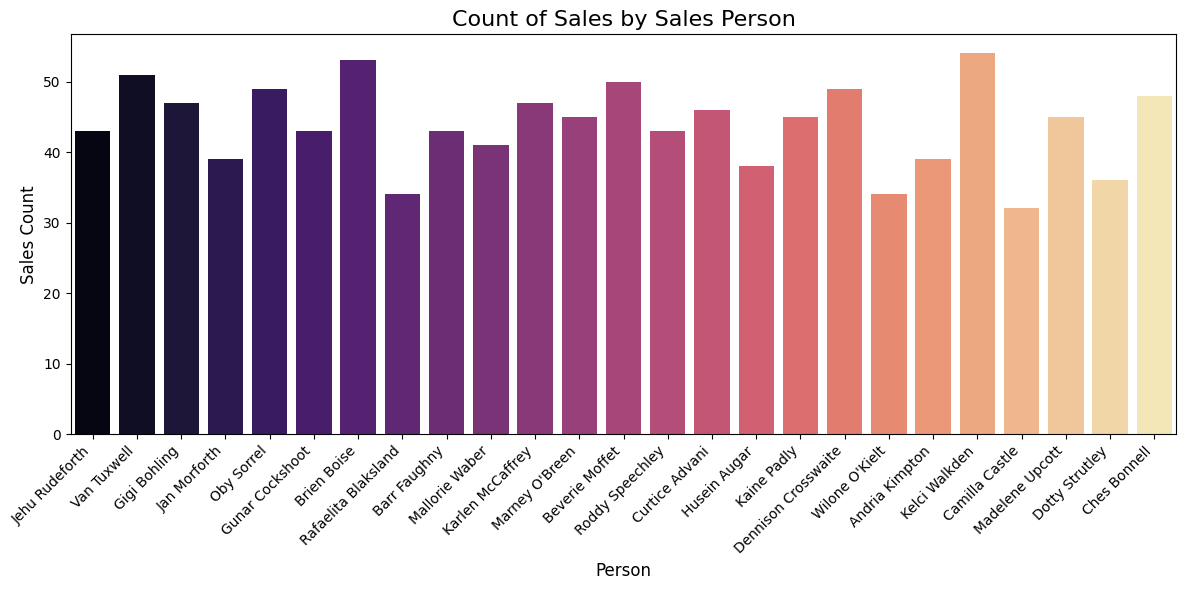

In [17]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_pandas, x='Sales Person', palette='magma', hue='Sales Person', legend=False)
plt.title('Count of Sales by Sales Person', fontsize=16)
plt.xlabel('Person', fontsize=12)
plt.ylabel('Sales Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

5. Vendas ao Longo do Tempo

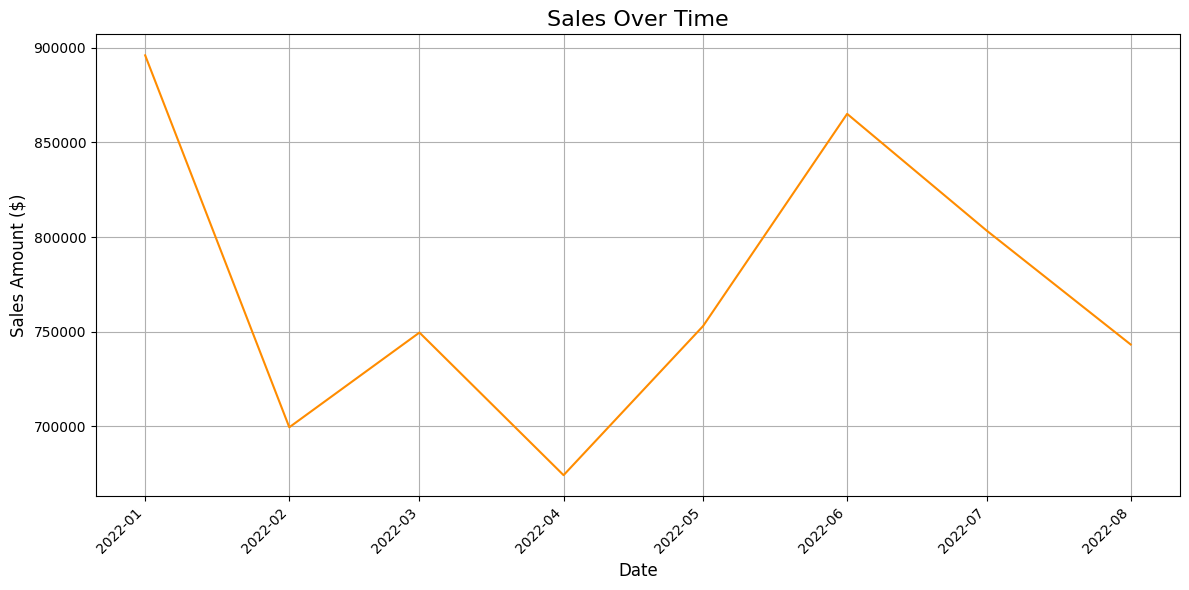

In [ ]:
# Garantir que a coluna 'Date' seja do tipo datetime
df_pandas['Date'] = pd.to_datetime(df_pandas['Date'])

# Agrupar por mês e somar a coluna 'Amount'
sales_over_time = df_pandas.groupby(df_pandas['Date'].dt.to_period('M'))['Amount'].sum().reset_index()

# Corrigir o erro de digitação e converter o período de volta para timestamp
sales_over_time['Date'] = sales_over_time['Date'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
sns.lineplot(data=sales_over_time, x='Date', y='Amount', color='darkorange')
plt.title('Sales Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Amount ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()


6. Caixas Enviadas

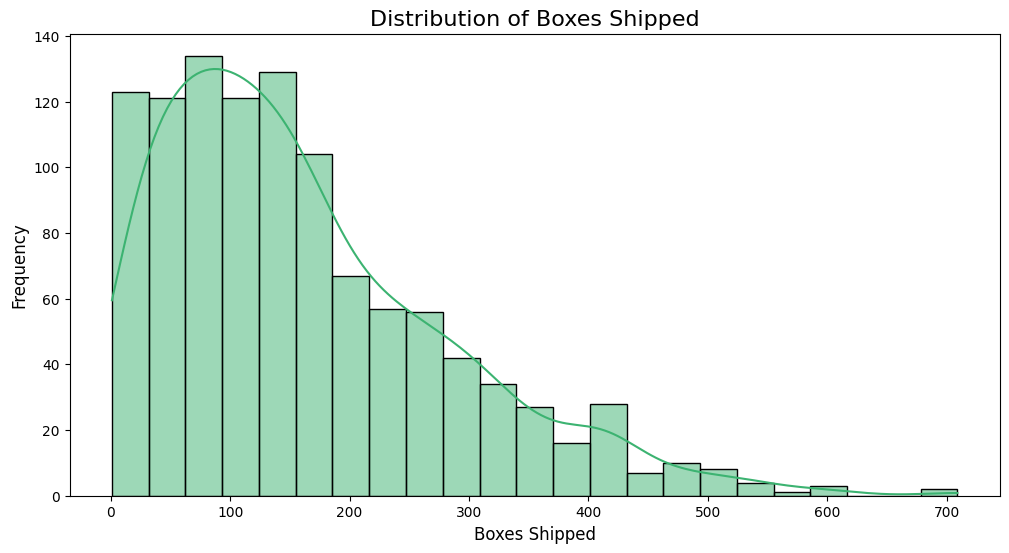

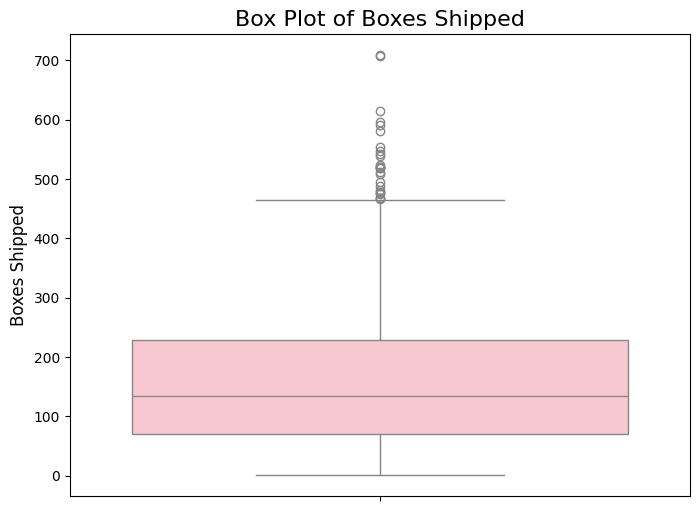

In [25]:
plt.figure(figsize=(12, 6))
sns.histplot(df_pandas['Boxes Shipped'], kde=True, color='mediumseagreen')
plt.title('Distribution of Boxes Shipped', fontsize=16)
plt.xlabel('Boxes Shipped', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(y=df_pandas['Boxes Shipped'], color='pink')
plt.title('Box Plot of Boxes Shipped', fontsize=16)
plt.ylabel('Boxes Shipped', fontsize=12)
plt.show()

7. Tendências de Vendas por País e Produto

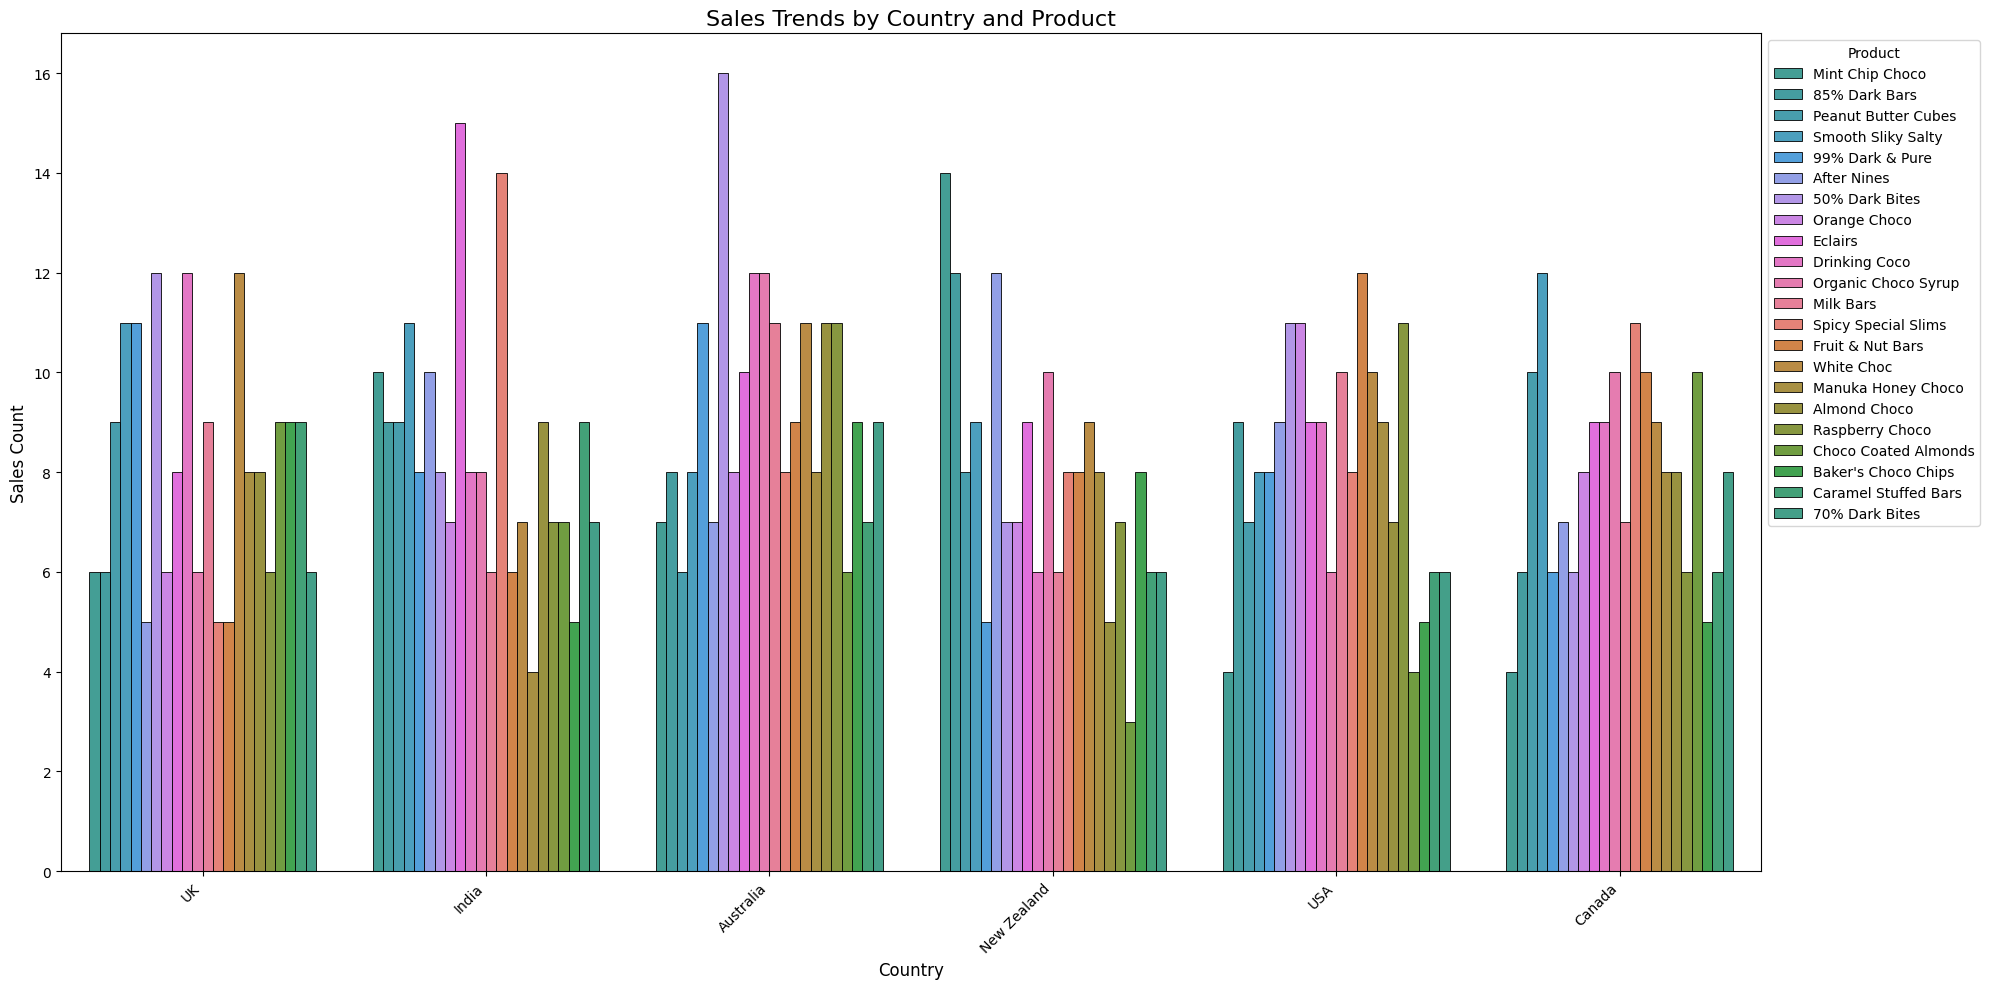

In [32]:
n_colors = 22
palette = sns.husl_palette(n_colors, h=0.5, s=0.9, l=0.65)

sns.set_palette(palette)

plt.figure(figsize=(20,10))
sns.countplot(data=df_pandas, x='Country' ,hue='Product', edgecolor='black', linewidth=0.6)
plt.title('Sales Trends by Country and Product', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Sales Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Product', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

8. Análise do desempenho dos vendedores

C:\Users\Leo\AppData\Local\Temp\ipykernel_2144\999266409.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales_person_sales, x='Sales Person', y='Total Sales', palette='viridis')


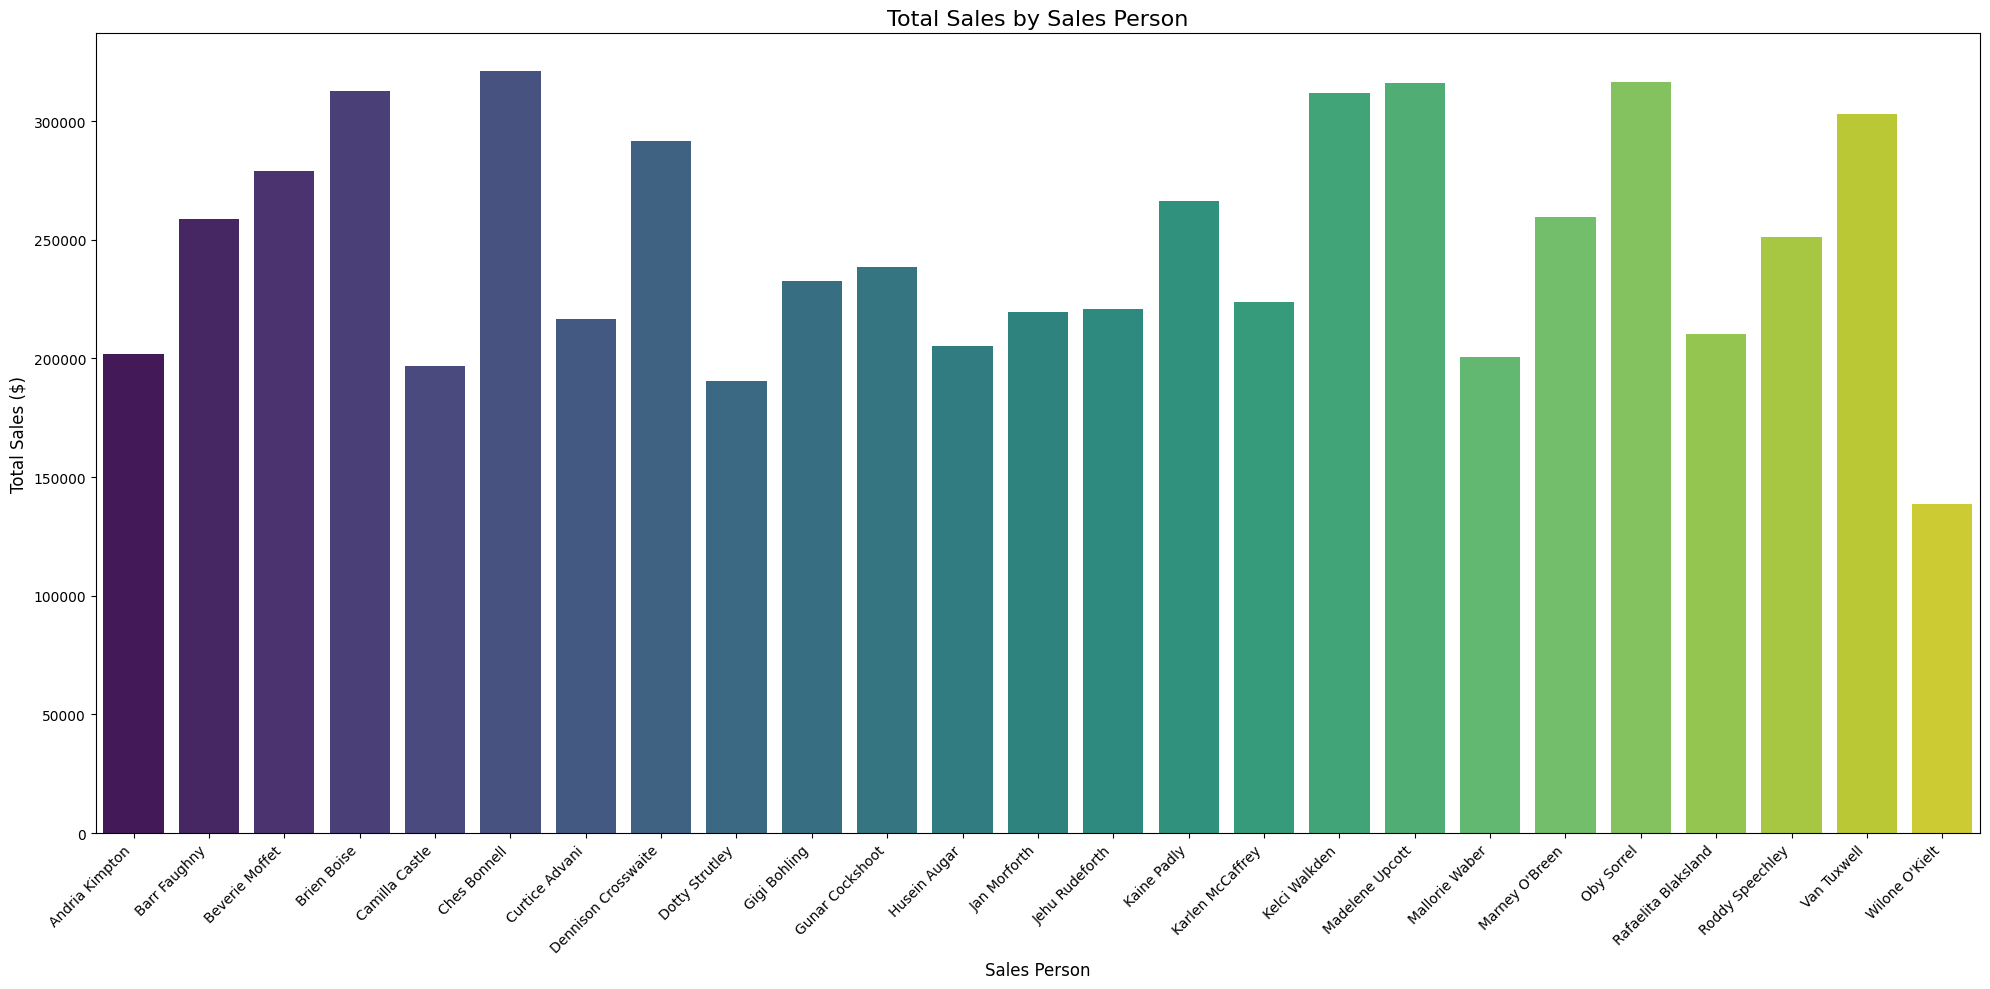

In [33]:
sales_person_sales = df_pandas.groupby('Sales Person').agg({'Amount': ['sum', 'mean']}).reset_index()
sales_person_sales.columns = ['Sales Person', 'Total Sales', 'Average Sales']

plt.figure(figsize=(20,10))
sns.barplot(data=sales_person_sales, x='Sales Person', y='Total Sales', palette='viridis')
plt.title('Total Sales by Sales Person', fontsize=16)
plt.xlabel('Sales Person', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()